Imports necessary libraries for data analysis, preprocessing, modeling, and visualization.

Creates an output directory named 'output' if it doesn't exist. This will be used to store output files or visualizations generated later in the code.

In [151]:
!pip install -U -q fcapy[all]==0.1.4

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import os 

from fcapy.mvcontext import MVContext, PS
from fcapy.mvcontext import pattern_structure as pslib
from fcapy.visualizer import LineVizNx
from fcapy.lattice import ConceptLattice
from fcapy.context import FormalContext
    
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)
 

<span style="font-size: 0.75em;">

# Financial Literacy Data Processing

This script processes and cleans datasets from two different years (2017 and 2020) related to financial literacy. The final output is a prepared DataFrame ready for further analysis or modeling. Below is a step-by-step explanation of the process:

## 1. Load Datasets and Compare Columns
The script begins by loading two datasets, one from 2017 and the other from 2020. It then compares the columns of these datasets:
- If the columns match, a message `"PASS_20_17"` is printed.
- If the columns do not match, the differences are identified and displayed.

## 2. Merge DataFrames and Initial Cleaning
Next, the two datasets are merged into a single DataFrame. Some initial data cleaning is performed:
- A new column `key` is added as a unique identifier, which is then set as the index of the DataFrame.
- The redundant `id` column is dropped.

## 3. Preprocess `qprod1_d`, `qprod2`, `qk4`, `qk5`, and `qf10_*` Variables
Certain variables require specific preprocessing:
- Missing values in specific columns (`qprod1_d` and `qprod2`) are filled with predefined values (`99` and `-99`, respectively).
- The variables `qk4` and `qk5` are recoded, grouping the answers of variables qk4 and qk5, imposing 1 on all incorrect answers.
- Variables that start with `qf10_` have invalid values (`-97`, `-99`) replaced with the mode (most frequent value) of each column to get an integer variable.

## 4. Define and Encode Variables
The script then categorizes the variables into three types:
- **Binary variables**: Variables with binary (0/1) responses.
- **Integer variables**: Variables with integer responses, including the `qf10_*` variables.
- **Continuous variables**: Variables with continuous numeric responses (e.g., `pesofitc`).

The remaining columns are treated as **categorical variables**. These categorical variables are encoded using `OneHotEncoder`, which converts them into binary (0/1) features.

## 5. Create and Finalize the Final DataFrame
The final DataFrame (`db_final`) is created by combining the binary, integer, and encoded categorical variables. Any remaining missing values are filled with `0`.

## 6. Check for Missing Values
Lastly, the script checks if there are any remaining missing values in the final DataFrame:
- If missing values are detected, a warning message is printed.
- If there are no missing values, a success message is displayed.

This structured approach ensures that the data is clean, consistent, and ready for any further analysis or machine learning tasks.

In [2]:
# 1. Load Datasets and Compare Columns
df_2017 = pd.read_csv("data/Financia_literacy_2017.csv")
df_2020 = pd.read_csv("data/Financia_literacy_2020.csv")

if (df_2020.columns == df_2017.columns).all():
    print("PASS_20_17")
else:
    print("FAIL_20_17")
    print("df_20: YES , df_17: NO", set(df_2020.columns) - set(df_2017.columns))
    print("df_17: YES , df_20: NO", set(df_2017.columns) - set(df_2020.columns))

# 2. Merge DataFrames and creates a new index
db = pd.concat([df_2017, df_2020], axis=0, ignore_index=True)
db['key'] = range(len(db))
db.set_index('key', inplace=True)
db.drop(columns=["id"], inplace=True)

# 3. Preprocess qprod1_d, qprod2, qk4, qk5, and qf10_* Variables
db.fillna({"qprod1_d": 99, "qprod2": -99}, inplace=True)

db['qk4'] = np.where(db['qk4'].isin([-97, -99, 0]), db['qk4'], 1)
db['qk5'] = np.where(db['qk5'].isin([-97, -99, 102]), db['qk5'], 1)

qf10_cols = [col for col in db.columns if col.startswith("qf10_")]
for col in qf10_cols:
    mode_value = db[col].mode()[0]
    db[col] = db[col].replace([-97, -99], mode_value)

# 4. Define Variables Type and Encode Variables Categorical ones
binary_variables = [
    "qd1", "SM", "qd12", "qprod1c_1", "qprod1c_2", "qprod1c_3", "qprod1c_5", "qprod1c_6", "qprod1c_7",
    "qprod1c_8", "qprod1c_10", "qprod1c_11", "qprod1c_12", "qprod1c_14", "qprod1c_99", "qf3_1", "qf3_3", "qf3_4",
    "qf3_6", "qf3_7", "qf3_8", "qf3_99", "qf9_1", "qf9_10", "qf9_2", "qf9_3", "qf9_4", "qf9_5", "qf9_6", "qf9_7",
    "qf9_8", "qf9_9", "qf9_99", "qprod3_1", "qprod3_2", "qprod3_3", "qprod3_4", "qprod3_5", "qprod3_6", "qprod3_7",
    "qprod3_8", "qprod3_9", "qprod3_10", "qprod3_11", "qprod3_12", "qprod3_13", "qprod3_14", "qprod3_15", "qprod3_16",
    "qprod3_17", "qprod3_18", "qprod3_99", "qf12_1_a", "qf12_1_b", "qf12_1_c", "qf12_2_d", "qf12_3_e", "qf12_3_f",
    "qf12_3_g", "qf12_4_k", "qf12_4_l", "qf12_5_m", "qf12_5_o", "qf12_6_p", "qf12_6_q", "qf12_7_r", "qf12_97", "qf12_99"
]
integer_variables = ["qd5b", "qd7"] + qf10_cols
continuous_variables = ["pesofitc"]

categorical_variables = db.columns.difference(binary_variables + integer_variables + continuous_variables)

encoder = OneHotEncoder(drop='first')
encoded_cols = encoder.fit_transform(db[categorical_variables])
encoded_df = pd.DataFrame(encoded_cols.toarray(), columns=encoder.get_feature_names_out(categorical_variables))

# 5. Create and Finalize the Final DataFrame
db_final = pd.concat([db[binary_variables + integer_variables], encoded_df], axis=1).fillna(0)

# 6. Check for Missing Values
if db_final.isna().any().any():
    print("Missing values exist.")
else:
    print("No missing values.")

PASS_20_17
No missing values.


<span style="font-size: 1em;">

### Variable Selection for Financial Literacy Analysis

In this analysis, I have specifically defined and selected variables based on the questions from the questionnaire that are directly used to calculate the financial literacy scores.
\\
These variables are categorized into three key components: **knowledge**, **behavior**, and **attitude**. 

In [ ]:
knowledge_score = ["qk3_2","qk3_3","qk3_-97","qk3_1", #qk3
                       "qk4_1","qk4_-97","qk4_0", #qk4
                       "qk5_1","qk5_-97","qk5_102", #qk5
                       "qk6_2","qk6_3","qk6_4","qk6_-97","qk6_1", #qk6
                       "qk7_1_0","qk7_1_-97","qk7_1_1", #qk7_1
                       "qk7_2_0","qk7_2_-97","qk7_2_1", #qk7_2
                       "qk7_3_0","qk7_3_-97","qk7_3_1",] #qk7_3

behevioral_score =  ["qf1_2","qf1_3","qf1_1", #qf1
                        "qf2_0","qf2_1", #qf2
                        "qf3_1","qf3_3","qf3_4","qf3_6","qf3_7","qf3_8","qf3_99", #qf3
                        #"qf10_1", #qf10_1
                        #"qf10_4", #qf10_4
                        #"qf10_6", #qf10_6
                        #"qf10_7", #qf10_7
                        "qprod2_2.0","qprod2_3.0","qprod2_4.0","qprod2_1.0", #qprod2
                        "qprod3_1","qprod3_2","qprod3_3","qprod3_4","qprod3_5","qprod3_6","qprod3_7","qprod3_8","qprod3_9","qprod3_10","qprod3_11","qprod3_12","qprod3_13","qprod3_14","qprod3_15","qprod3_16","qprod3_17","qprod3_18","qprod3_99", #qprod3
                        "qf12_1_a","qf12_1_b","qf12_1_c","qf12_2_d","qf12_3_e","qf12_3_f","qf12_3_g","qf12_4_k","qf12_4_l","qf12_5_m","qf12_5_o","qf12_6_p","qf12_6_q","qf12_7_r","qf12_97","qf12_99" #qf12
                        ]

attitude_score = ["qf10_2","qf10_3","qf10_8"] #qf10

proviamo


In [ ]:
variables = behevioral_score + knowledge_score
db = db_final[variables]
db = db.astype(bool)
db.index = db.index.astype(str)
db_1 = db.iloc[1:100,]

In [47]:
db

,qf1_2,qf1_3,qf1_1,qf2_0,qf2_1,qf3_1,qf3_3,qf3_4,qf3_6,qf3_7,...,qk6_1,qk7_1_0,qk7_1_-97,qk7_1_1,qk7_2_0,qk7_2_-97,qk7_2_1,qk7_3_0,qk7_3_-97,qk7_3_1
0,1.0,0.0,0.0,1.0,0.0,0,0,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0,0,0,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,0.0,1.0,0.0,0.0,1.0,1,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4748,0.0,0.0,1.0,1.0,0.0,1,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4749,0.0,1.0,0.0,0.0,1.0,1,0,0,0,0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4750,0.0,1.0,0.0,1.0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [25]:
K = FormalContext.from_pandas(db)

In [ ]:
def calculate_metrics(df, attributes_a, attributes_b):
    """
    Calcola il supporto, la confidenza e il lift per tutte le combinazioni tra A e B.
    
    Parameters:
    -----------
    df : pd.DataFrame
        La tabella con i dati (1/0 per relazioni binarie).
    attributes_a : list
        Lista di attributi appartenenti al sottoinsieme A.
    attributes_b : list
        Lista di attributi appartenenti al sottoinsieme B.
    
    Returns:
    --------
    results : list of tuples
        Ogni elemento è una tupla (attr_a, comb_b, support, confidence, lift).
    """
    results = []
    total_rows = len(df)
    
    # Per ogni attributo in A
    for attr_a in attributes_a:
        # Supporto di A
        support_a = df[attr_a].sum() / total_rows
        
        if support_a == 0:
            continue  # Evita divisioni per 0
        
        # Per ogni combinazione di attributi in B
        for r in range(1, len(attributes_b) + 1):  # Combinazioni di lunghezza 1 a len(B)
            for comb_b in combinations(attributes_b, r):
                # Calcola il supporto di A ∩ B
                support_comb = df[list(comb_b)].all(axis=1) & df[attr_a]
                support_comb = support_comb.sum() / total_rows
                
                # Calcola il supporto di B (combinazione)
                support_b = df[list(comb_b)].all(axis=1).sum() / total_rows
                
                # Calcola la confidenza e il lift
                confidence = support_comb / support_a if support_a > 0 else 0
                lift = confidence / support_b if support_b > 0 else 0
                
                # Salva il risultato
                results.append((attr_a, comb_b, support_comb, confidence, lift))
    
    return results


TypeError: object of type 'FormalContext' has no len()

In [48]:
print(K)
print(K.object_names)
print(K.attribute_names)

FormalContext (4752 objects, 75 attributes, 52832 connections)
    |qf1_2|qf1_3|qf1_1|qf2_0|qf2_1|...|qk7_2_-97|qk7_2_1|qk7_3_0|qk7_3_-97|qk7_3_1|
0   |    X|     |     |    X|     |...|         |      X|      X|         |       |
1   |    X|     |     |     |    X|...|         |      X|       |         |      X|
2   |     |     |    X|    X|     |...|         |      X|       |         |      X|
3   |    X|     |     |    X|     |...|         |      X|       |        X|       |
4   |    X|     |     |    X|     |...|         |       |      X|         |       |
5   |    X|     |     |    X|     |...|         |      X|      X|         |       |
6   |    X|     |     |     |    X|...|         |      X|       |         |       |
7   |    X|     |     |    X|     |...|         |      X|       |        X|       |
8   |     |     |    X|    X|     |...|         |      X|       |        X|       |
9   |    X|     |     |    X|     |...|        X|       |       |        X|       |
.............

Con la funzione extension si possono vedere tutti gli oggetti che hanno in comune un determinato attributo

In [45]:
K.extension(["qf1_2"])

['0',
 '1',
 '3',
 '4',
 '5',
 '6',
 '7',
 '9',
 '10',
 '11',
 '14',
 '17',
 '19',
 '20',
 '22',
 '24',
 '25',
 '27',
 '30',
 '31',
 '32',
 '33',
 '35',
 '36',
 '37',
 '38',
 '39',
 '42',
 '43',
 '44',
 '46',
 '48',
 '51',
 '55',
 '58',
 '59',
 '60',
 '62',
 '63',
 '64',
 '67',
 '68',
 '71',
 '72',
 '73',
 '78',
 '79',
 '82',
 '83',
 '84',
 '85',
 '87',
 '88',
 '89',
 '91',
 '93',
 '94',
 '96',
 '97',
 '99',
 '101',
 '102',
 '103',
 '105',
 '106',
 '107',
 '108',
 '109',
 '111',
 '113',
 '115',
 '117',
 '119',
 '120',
 '122',
 '123',
 '124',
 '126',
 '128',
 '130',
 '131',
 '136',
 '137',
 '139',
 '140',
 '142',
 '149',
 '150',
 '154',
 '157',
 '159',
 '160',
 '165',
 '167',
 '168',
 '169',
 '175',
 '177',
 '178',
 '179',
 '180',
 '182',
 '183',
 '184',
 '186',
 '187',
 '188',
 '189',
 '190',
 '192',
 '193',
 '194',
 '195',
 '196',
 '197',
 '198',
 '199',
 '201',
 '202',
 '205',
 '206',
 '207',
 '208',
 '209',
 '211',
 '212',
 '214',
 '215',
 '216',
 '217',
 '218',
 '221',
 '222',
 '22

Con la funzione intention possiamo vedere gli attributi che condividono diversi oggetti

In [13]:
K.intention(["2","4"])

['qf2_0', 'qf3_8']

La classe FormalContext può essere salvata in json o in csv tramite i metodi "write_csv" e "write_json" e supporta in import ed in export anche i formati pandas

In [47]:
K.write_json(f'{output_dir}\\prova.json')
K.write_csv(f'{output_dir}\\prova.csv', sep=',', word_true='1', word_false='0')

In [20]:
L = ConceptLattice.from_context(K)
print("# concepts:", len(L))

# concepts: 553


In [52]:
L_mv = ConceptLattice.from_context(K, algo='Sofia', L_max=100)
print(len(L_mv))

99


In [36]:
ConceptLattice.from_context??

Signature:
ConceptLattice.from_context(
    context: Union[fcapy.context.formal_context.FormalContext, fcapy.mvcontext.mvcontext.MVContext],
    algo: Optional[str] = None,
    **kwargs,
)
Source:   
    @classmethod
    def from_context(
            cls,
            context: Union[FormalContext, MVContext],
            algo: Optional[str] = None, **kwargs
    ):
        """Return a `ConceptLattice` constructed on the ``context`` by algorithm ``algo``

        Parameters
        ----------
        context: 'FormalContext` or 'MVContext`
        algo: `str` in {'CbO', 'Sofia', 'RandomForest'}
        kwargs:
            Parameters used in CbO, Sofia and RandomForest algorithms from `fcapy.algorithms.concept_construction` module

        Returns
        -------
        ltc: `ConceptLattice`
            A concept lattice constructed on the ``context`` by algorithm ``algo``

        """
        if algo is None:
            algo = 'CbO' if type(context) == MVContext else 'Lindig'

        i

Please, modify the ``pos`` dictionary parameter manually. You can obtain the default ``pos`` via Mover.initialize_pos(...) function.

The problematic edges and nodes (in the form of {edge: overlapped nodes indexes}) are:
{(35, 94): frozenset({40})}


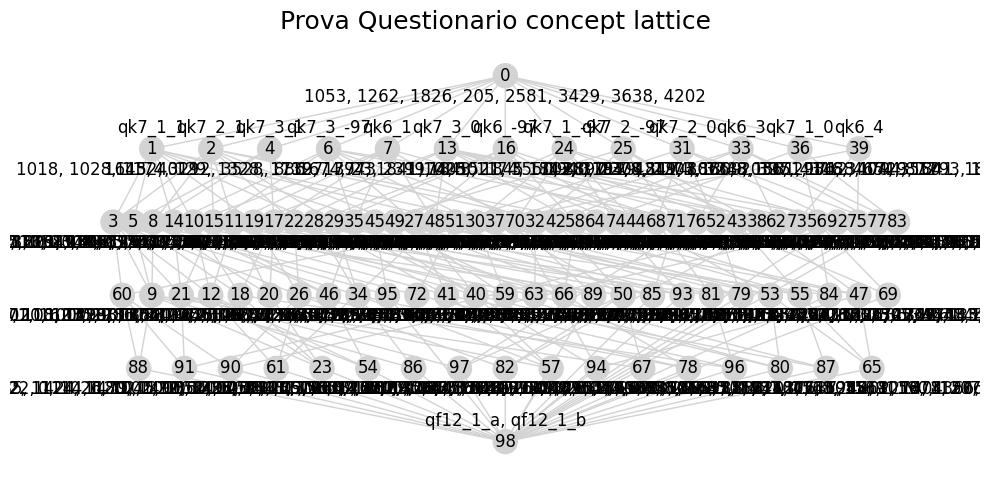

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
vsl = LineVizNx()
vsl.draw_concept_lattice(
    L_mv, ax=ax, flg_node_indices=True,
    max_new_extent_count=10, flg_new_intent_count_prefix=False, flg_new_extent_count_prefix=False
)
ax.set_xlim(ax.get_xlim()[0]-0.05, ax.get_xlim()[1])
plt.title('Prova Questionario concept lattice', size=18)
plt.tight_layout()
plt.show()

Possiamo accedere ai singoli Concept in questo modo, modificando i

In [13]:
i = 46
c = L[i]
print(f"Concept {i}:\nextent {c.extent}\nintent {c.intent}")

Concept 46:
extent ('2', '3', '7', '8', '11', '13', '19')
intent ('qf2_0', 'qf3_8', 'qk7_2_1')


In [14]:
for i, c in enumerate(L):
    print(f"Concept {i}:\nextent {c.extent}\nintent {c.intent}")
    print(f"intent lenght - {len(c.intent)}")
    print(f"extent lenght - {len(c.extent)}\n\n")

Concept 0:
extent ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19')
intent ()
intent lenght - 0
extent lenght - 19


Concept 1:
extent ('1', '2', '3', '5', '6', '8', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19')
intent ('qk7_1_1',)
intent lenght - 1
extent lenght - 16


Concept 2:
extent ('1', '2', '3', '5', '6', '7', '8', '10', '11', '12', '13', '14', '15', '18', '19')
intent ('qk7_2_1',)
intent lenght - 1
extent lenght - 15


Concept 3:
extent ('2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '15', '17', '18', '19')
intent ('qf2_0',)
intent lenght - 1
extent lenght - 15


Concept 4:
extent ('1', '2', '3', '5', '6', '8', '10', '11', '12', '13', '14', '15', '18', '19')
intent ('qk7_1_1', 'qk7_2_1')
intent lenght - 2
extent lenght - 14


Concept 5:
extent ('1', '2', '5', '6', '9', '10', '11', '12', '13', '14', '16', '17', '18')
intent ('qk3_3',)
intent lenght - 1
extent lenght - 13


Concept 6:
extent ('1', 

In [15]:
for i, c in enumerate(L):
    if len(c.extent) > 1:  # Verifica che la lunghezza dell'extent sia maggiore di 1
        print(f"Concept {i}:\nextent {c.extent}\nintent {c.intent}")
        print(f"intent length - {len(c.intent)}")
        print(f"extent length - {len(c.extent)}")
        print(f"{i}\n\n")

Concept 0:
extent ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19')
intent ()
intent length - 0
extent length - 19
0


Concept 1:
extent ('1', '2', '3', '5', '6', '8', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19')
intent ('qk7_1_1',)
intent length - 1
extent length - 16
1


Concept 2:
extent ('1', '2', '3', '5', '6', '7', '8', '10', '11', '12', '13', '14', '15', '18', '19')
intent ('qk7_2_1',)
intent length - 1
extent length - 15
2


Concept 3:
extent ('2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '15', '17', '18', '19')
intent ('qf2_0',)
intent length - 1
extent length - 15
3


Concept 4:
extent ('1', '2', '3', '5', '6', '8', '10', '11', '12', '13', '14', '15', '18', '19')
intent ('qk7_1_1', 'qk7_2_1')
intent length - 2
extent length - 14
4


Concept 5:
extent ('1', '2', '5', '6', '9', '10', '11', '12', '13', '14', '16', '17', '18')
intent ('qk3_3',)
intent length - 1
extent length - 13
5


Concept 6:
e

# MVContext

In [56]:
knowledge_score = ["qk3_2","qk3_3","qk3_-97","qk3_1", #qk3
                       "qk4_1","qk4_-97","qk4_0", #qk4
                       "qk5_1","qk5_-97","qk5_102", #qk5
                       "qk6_2","qk6_3","qk6_4","qk6_-97","qk6_1", #qk6
                       "qk7_1_0","qk7_1_-97","qk7_1_1", #qk7_1
                       "qk7_2_0","qk7_2_-97","qk7_2_1", #qk7_2
                       "qk7_3_0","qk7_3_-97","qk7_3_1",] #qk7_3

behevioral_score =  ["qf1_2","qf1_3","qf1_1", #qf1
                        "qf2_0","qf2_1", #qf2
                        "qf3_1","qf3_3","qf3_4","qf3_6","qf3_7","qf3_8","qf3_99", #qf3
                        "qf10_1", #qf10_1 #DA 1 A 5
                        "qf10_4", #qf10_4 #DA 1 A 5
                        "qf10_6", #qf10_6 #DA 1 A 5
                        "qf10_7", #qf10_7 #DA 1 A 5
                        "qprod2_2.0","qprod2_3.0","qprod2_4.0","qprod2_1.0", #qprod2
                        "qprod3_1","qprod3_2","qprod3_3","qprod3_4","qprod3_5","qprod3_6","qprod3_7","qprod3_8","qprod3_9","qprod3_10","qprod3_11","qprod3_12","qprod3_13","qprod3_14","qprod3_15","qprod3_16","qprod3_17","qprod3_18","qprod3_99", #qprod3
                        "qf12_1_a","qf12_1_b","qf12_1_c","qf12_2_d","qf12_3_e","qf12_3_f","qf12_3_g","qf12_4_k","qf12_4_l","qf12_5_m","qf12_5_o","qf12_6_p","qf12_6_q","qf12_7_r","qf12_97","qf12_99" #qf12
                        ]

attitude_score = ["qf10_2","qf10_3","qf10_8"] #qf10

variabili_intere = ["qf10_1", 
                    "qf10_4", 
                    "qf10_6", 
                    "qf10_7"]

In [62]:
variables = behevioral_score + knowledge_score
db = db_final[variables]
db.index = db.index.astype(str)
db_1 = db.iloc[1:10,]

In [63]:
ptypes = {f: PS.IntervalPS for f in db_1[variables]}

In [65]:
K = MVContext(
    db_1.values, pattern_types=ptypes,
    object_names=('individuo_'+db_1.index.astype(str)).tolist(),
    attribute_names=db_1.columns.tolist(),
)

In [70]:
K.intention_i([0,7])

{0: (np.float32(0.0), np.float32(1.0)),
 1: (np.float32(0.0), np.float32(0.0)),
 2: (np.float32(0.0), np.float32(1.0)),
 3: (np.float32(0.0), np.float32(1.0)),
 4: (np.float32(0.0), np.float32(1.0)),
 5: (np.float32(0.0), np.float32(0.0)),
 6: (np.float32(0.0), np.float32(0.0)),
 7: (np.float32(0.0), np.float32(0.0)),
 8: (np.float32(0.0), np.float32(1.0)),
 9: (np.float32(0.0), np.float32(0.0)),
 10: (np.float32(0.0), np.float32(1.0)),
 11: (np.float32(0.0), np.float32(0.0)),
 12: (np.float32(1.0), np.float32(1.0)),
 13: (np.float32(1.0), np.float32(1.0)),
 14: (np.float32(1.0), np.float32(3.0)),
 15: (np.float32(2.0), np.float32(3.0)),
 16: (np.float32(0.0), np.float32(0.0)),
 17: (np.float32(0.0), np.float32(1.0)),
 18: (np.float32(0.0), np.float32(0.0)),
 19: (np.float32(0.0), np.float32(1.0)),
 20: (np.float32(0.0), np.float32(0.0)),
 21: (np.float32(0.0), np.float32(0.0)),
 22: (np.float32(0.0), np.float32(0.0)),
 23: (np.float32(1.0), np.float32(1.0)),
 24: (np.float32(0.0), np.

In [73]:
K.intention(["individuo_0","individuo_7","individuo_3"])

{'qf1_2': (np.float32(1.0), np.float32(1.0)),
 'qf1_3': (np.float32(0.0), np.float32(0.0)),
 'qf1_1': (np.float32(0.0), np.float32(0.0)),
 'qf2_0': (np.float32(1.0), np.float32(1.0)),
 'qf2_1': (np.float32(0.0), np.float32(0.0)),
 'qf3_1': (np.float32(0.0), np.float32(0.0)),
 'qf3_3': (np.float32(0.0), np.float32(0.0)),
 'qf3_4': (np.float32(0.0), np.float32(0.0)),
 'qf3_6': (np.float32(0.0), np.float32(0.0)),
 'qf3_7': (np.float32(0.0), np.float32(0.0)),
 'qf3_8': (np.float32(1.0), np.float32(1.0)),
 'qf3_99': (np.float32(0.0), np.float32(0.0)),
 'qf10_1': (np.float32(1.0), np.float32(1.0)),
 'qf10_4': (np.float32(1.0), np.float32(1.0)),
 'qf10_6': (np.float32(1.0), np.float32(1.0)),
 'qf10_7': (np.float32(2.0), np.float32(3.0)),
 'qprod2_2.0': (np.float32(0.0), np.float32(0.0)),
 'qprod2_3.0': (np.float32(0.0), np.float32(0.0)),
 'qprod2_4.0': (np.float32(0.0), np.float32(0.0)),
 'qprod2_1.0': (np.float32(0.0), np.float32(0.0)),
 'qprod3_1': (np.float32(0.0), np.float32(0.0)),
 'qpro

In [74]:
K.extension({'qf10_7': (1, 2)})

['individuo_1', 'individuo_3']

In [33]:
L_mv = ConceptLattice.from_context(K, algo='Sofia', L_max=90)
print(len(L_mv))

3


Estraiamo i 3 concetti più stabili

In [76]:
indexes = [0, 1, 2]
for i, c in zip(indexes, L_mv[indexes]):
    ext_verb = ', '.join(c.extent[:10]) + ('...' if len(c.extent)>10 else '')
    int_verb = '\n\t'.join([f"{k}: {v}" for k,v in c.intent.items()])
    print(f"Concept {i}:\nextent {ext_verb}\nintent {int_verb}\n")

Concept 0:
extent individuo_1, individuo_2, individuo_3, individuo_4, individuo_5, individuo_6, individuo_7, individuo_8, individuo_9
intent qf1_2: (np.float32(0.0), np.float32(1.0))
	qf1_3: (np.float32(0.0), np.float32(0.0))
	qf1_1: (np.float32(0.0), np.float32(1.0))
	qf2_0: (np.float32(0.0), np.float32(1.0))
	qf2_1: (np.float32(0.0), np.float32(1.0))
	qf3_1: (np.float32(0.0), np.float32(0.0))
	qf3_3: (np.float32(0.0), np.float32(0.0))
	qf3_4: (np.float32(0.0), np.float32(0.0))
	qf3_6: (np.float32(0.0), np.float32(1.0))
	qf3_7: (np.float32(0.0), np.float32(0.0))
	qf3_8: (np.float32(0.0), np.float32(1.0))
	qf3_99: (np.float32(0.0), np.float32(1.0))
	qf10_1: (np.float32(1.0), np.float32(2.0))
	qf10_4: (np.float32(1.0), np.float32(2.0))
	qf10_6: (np.float32(1.0), np.float32(4.0))
	qf10_7: (np.float32(2.0), np.float32(5.0))
	qprod2_2.0: (np.float32(0.0), np.float32(0.0))
	qprod2_3.0: (np.float32(0.0), np.float32(1.0))
	qprod2_4.0: (np.float32(0.0), np.float32(0.0))
	qprod2_1.0: (np.float3

# Pattern Structure

In [152]:
variabili_intere = ["qf10_7"]

variabili_binarie = ["qk3_2","qk3_3","qk3_-97","qk3_1"]

variables = variabili_intere + variabili_binarie

In [ ]:
db = db_final[variables]
db.index = db.index.astype(str)
db.loc[:,variabili_binarie] = db.loc[:,variabili_binarie].astype(bool)
db_1 = db.iloc[1:20,]

C:\Users\lore9\AppData\Local\Temp\ipykernel_13504\1941924827.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ...  True False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  db.loc[:,variabili_binarie] = db.loc[:,variabili_binarie].astype(bool)
C:\Users\lore9\AppData\Local\Temp\ipykernel_13504\1941924827.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ... False False  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  db.loc[:,variabili_binarie] = db.loc[:,variabili_binarie].astype(bool)
C:\Users\lore9\AppData\Local\Temp\ipykernel_13504\1941924827.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False  True 

In [154]:
db_1.head()

,qf10_7,qk3_2,qk3_3,qk3_-97,qk3_1
1,2,False,True,False,False
2,3,False,True,False,False
3,2,True,False,False,False
4,3,True,False,False,False
5,4,False,True,False,False


In [157]:
ptypes = {
            "qf10_7" : pslib.IntervalPS,
            "qk3_2" : pslib.BinaryPS,
            "qk3_3" : pslib.BinaryPS,
            "qk3_-97" : pslib.BinaryPS,
            "qk3_1" : pslib.BinaryPS
}
MK = MVContext(db_1.values, ptypes, object_names=db_1.index, attribute_names=db_1.columns)

AttributeError: module 'fcapy.mvcontext.pattern_structure' has no attribute 'BinaryPS'

In [136]:
MK.intention(MK.object_names)

{'qf10_7': (np.float32(2.0), np.float32(5.0))}

In [138]:
MK.describe_pattern(MK.intention(MK.object_names))

AttributeError: 'MVContext' object has no attribute 'describe_pattern'

In [ ]:
L = ConceptLattice.from_context(MK)

11

In [139]:
L.calc_concepts_measures('LStab', MK)
stabs = pd.Series([c.measures['LStab'] for c in L]).sort_values(ascending=False)
best_stabs = stabs[stabs>=0.1]
best_concepts = L[best_stabs.index]
L_best = ConceptLattice(sorted(set(best_concepts+[L[0], L[-1]]), key=lambda c: -c.support))
print(len(L_best))

11


AttributeError: 'MVContext' object has no attribute 'describe_pattern'

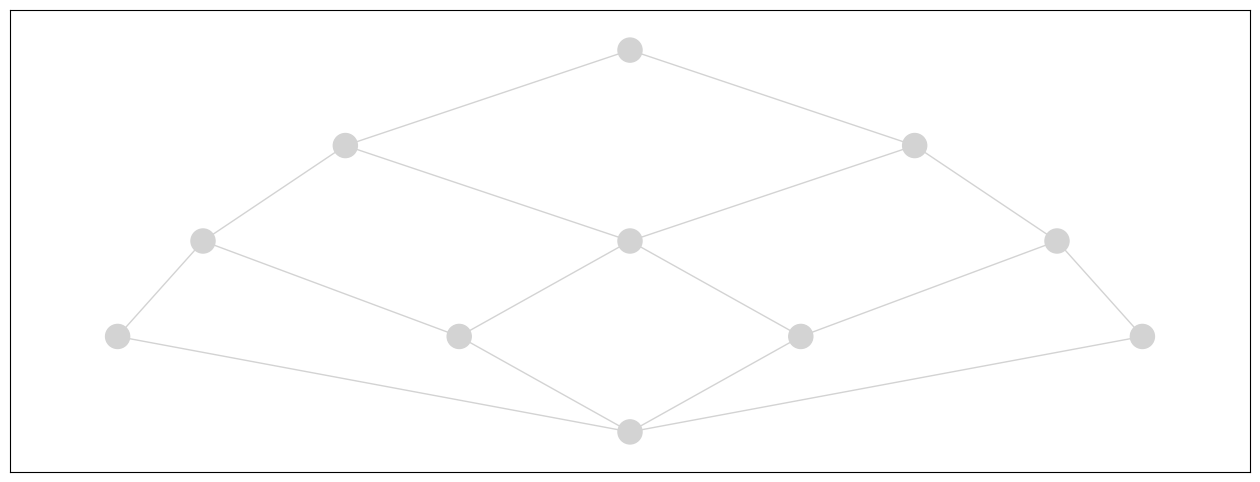

In [144]:
fig, ax = plt.subplots(figsize=(16,6))

viz = LineVizNx()
viz.draw_concept_lattice(
    L_best, ax=ax,
    node_label_func=lambda el_i, L: MK.describe_pattern(L[el_i].intent).replace(';', '\n')
)

plt.tight_layout()
plt.show()